In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

os.environ['disable_tqdm'] = 'true'

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils import graph_utils
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
import pickle as pkl
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
# y = snakemake_utils.get_dataset("airport").get_grouped_col()
# sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
# DATA_ROOT = '/data/sg/ashutiwa/final_crosswalk/airport/'

# DIRS = ['airport_one/', 'airport_two/', 'airport_three/', 'airport_four/', 'airport_five/']
# DATASET = 'airport'


# TEST_ADJ_FILE='/data/sg/ashutiwa/final_crosswalk/airport/airport_one/airport_test_adj.npz'
# NUM_NODES=2898
# k=5


y = snakemake_utils.get_dataset("polblog").get_grouped_col()
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_crosswalk/polblog/'
model_to_embs = {
    "GCN_baseline": '_gcn_None_deepwalk_deepwalk_embs.npy',
    "GCN_r2v": '_gcn_None_deepwalk_r2v_embs.npy',
    "GCN_baseline_fairwalk": "_gcn_fairwalk_deepwalk_deepwalk_embs.npy", 
    "GCN_r2v_fairwalk": "_gcn_fairwalk_deepwalk_r2v_embs.npy",
    "GAT_baseline": '_gat_None_deepwalk_deepwalk_embs.npy',
    "GAT_r2v": '_gat_None_deepwalk_r2v_embs.npy',
    "GAT_baseline_fairwalk": "_gat_fairwalk_deepwalk_deepwalk_embs.npy", 
    "GAT_r2v_fairwalk": "_gat_fairwalk_deepwalk_r2v_embs.npy",
    
    "word2vec_baseline": '_word2vec_None_deepwalk_deepwalk_embs.npy',
    "word2vec_r2v": '_word2vec_None_deepwalk_r2v_embs.npy',
    "word2vec_baseline_fairwalk": "_word2vec_fairwalk_deepwalk_deepwalk_embs.npy", 
    "word2vec_r2v_fairwalk": "_word2vec_fairwalk_deepwalk_r2v_embs.npy"
}
M = list(model_to_embs.keys())
DIRS = ['polblog_one/', 'polblog_two/', 'polblog_three/', 'polblog_four/', 'polblog_five/']
DATASET = 'polblog'


TEST_ADJ_FILE='/data/sg/ashutiwa/final_crosswalk/polblog/polblog_one/polblog_test_adj.npz'
NUM_NODES=1224
k=5

# distributions of positive and negative edgeswith dot product

In [4]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [5]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [6]:
FILE_CACHE = {}
def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    EDGE_IDX = snakemake_utils.get_edge_index_from_sparse_path(file)
    if file in FILE_CACHE:
        NEGATIVE_EDGE_IDX, EDGE_IDX = FILE_CACHE[file]
    else:
        NEGATIVE_EDGE_IDX, EDGE_IDX = graph_utils._negative_sampling_sparse(edge_index=EDGE_IDX, n_nodes=NUM_NODES, return_pos_samples=True)
        FILE_CACHE[file] = (NEGATIVE_EDGE_IDX, EDGE_IDX)
    print("selected edge_idx size: {}".format(EDGE_IDX.size(1)))

    positive_dot = np.sum(A[EDGE_IDX[0,:]] * A[EDGE_IDX[1,:]], axis=1)
    negative_dot = np.sum(A[NEGATIVE_EDGE_IDX[0,:]] * A[NEGATIVE_EDGE_IDX[1,:]], axis=1)
    dot = pd.DataFrame()
    dot["positive_dot"] = positive_dot
    dot["negative_dot"] = negative_dot
    
    return dot

# word2vec baseline

In [7]:
model = "word2vec_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 34


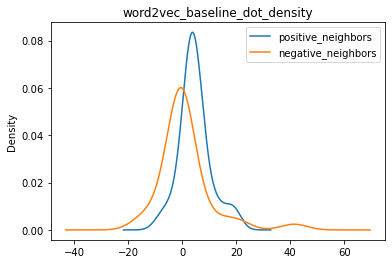

In [8]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [9]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5957.54it/s]


((6120, 2), 0.001847738214459733, 0.7681660899653979, 0.14639957643539456)

# word2vec fairwalk

In [10]:
model = "word2vec_baseline_fairwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(1224, 128)

selected edge_idx size: 34


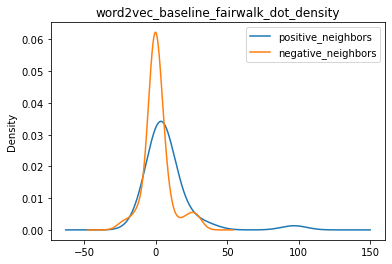

In [11]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [12]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6404.00it/s]


((6120, 2), 0.0019586345147395174, 0.7102076124567474, 0.14798709273447994)

# word2vec r2v

In [13]:
model = "word2vec_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 34


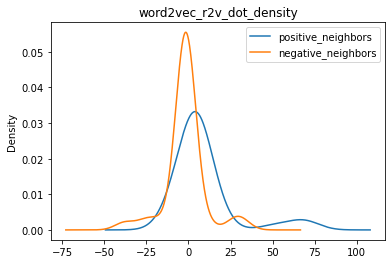

In [14]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [15]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6264.60it/s]


((6120, 2), 0.001511271119122626, 0.7846020761245674, 0.12139364704161512)

# word2vec r2v fairwalk

In [16]:
model = "word2vec_r2v_fairwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 34


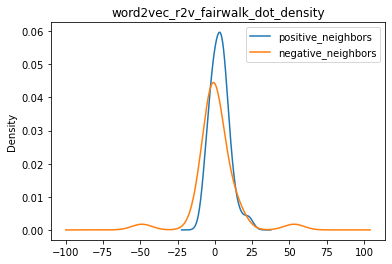

In [17]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [18]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6339.89it/s]


((6120, 2), 0.001355275658433856, 0.643598615916955, 0.10948371757899747)

# GCN ( baseline)

In [19]:
model = "GCN_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 34


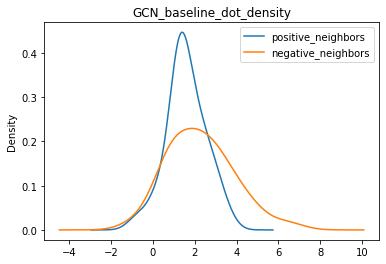

In [20]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [21]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4661.19it/s]


((6114, 2), 0.004722360190206297, 0.38321799307958476, 0.30149138003105286)

# GCN ( baseline + fairwalk)

In [22]:
model = "GCN_baseline_fairwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(1224, 128)

selected edge_idx size: 34


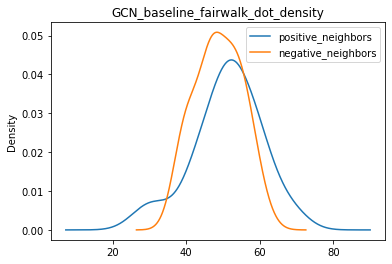

In [23]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [24]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5107.86it/s]


((6114, 2), 0.004372502574849588, 0.606401384083045, 0.2948409182707438)

# GCN ( r2v)

In [25]:
model = "GCN_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 34


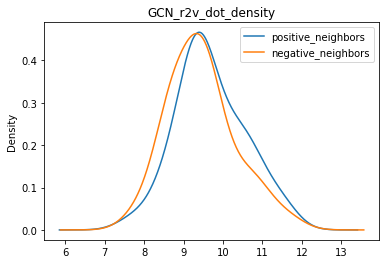

In [26]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [27]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5743.69it/s]


((6116, 2), 0.0048641268204860505, 0.5787197231833909, 0.31530092934309367)

# GCN ( r2v + fairwalk)

In [28]:
model = "GCN_r2v_fairwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 34


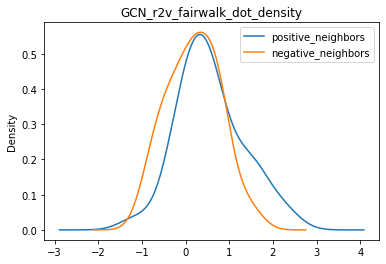

In [29]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [30]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6353.27it/s]


((6120, 2), 0.0035733945828039892, 0.6358131487889274, 0.24683748292682037)

# GAT ( baseline)

In [31]:
model = "GAT_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 34


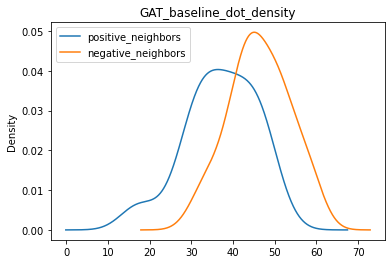

In [32]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [33]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5703.74it/s]


((6104, 2), 0.004867546644117873, 0.20761245674740486, 0.3149355626360445)

# GAT ( baseline + fairwalk)

In [34]:
model = "GAT_baseline_fairwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 34


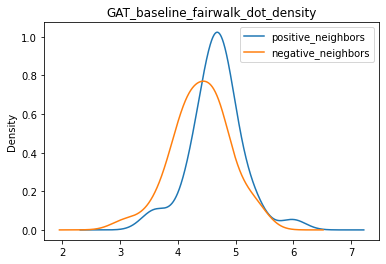

In [35]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [36]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6202.03it/s]


((6110, 2), 0.004268937655253699, 0.6738754325259515, 0.2903259341449173)

# GAT ( r2v)

In [37]:
model = "GAT_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 34


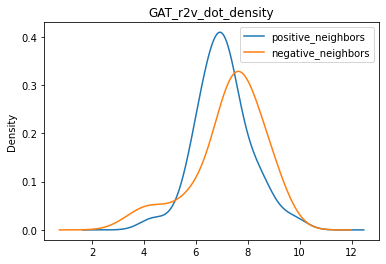

In [38]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [39]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6390.24it/s]


((6120, 2), 0.00462171072349961, 0.3780276816608997, 0.3077505349135706)

# GAT ( r2v + fairwalk)

In [40]:
model = "GAT_r2v_fairwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 34


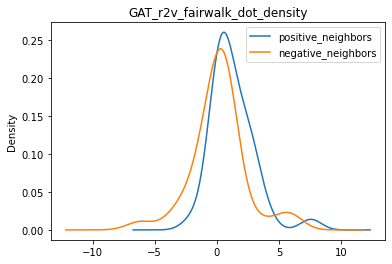

In [41]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [42]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6069.76it/s]


((6120, 2), 0.003568560045099069, 0.6730103806228374, 0.24602824755231262)

# plot statistical parity scores

# gini sp scores

word2vec_baseline 0.14639957643539456
word2vec_baseline_fairwalk 0.14798709273447994
word2vec_r2v 0.12139364704161512
word2vec_r2v_fairwalk 0.10948371757899747
GCN_baseline 0.30149138003105286
GCN_baseline_fairwalk 0.2948409182707438
GCN_r2v 0.31530092934309367
GCN_r2v_fairwalk 0.24683748292682037
GAT_baseline 0.3149355626360445
GAT_baseline_fairwalk 0.2903259341449173
GAT_r2v 0.3077505349135706
GAT_r2v_fairwalk 0.24602824755231262


Text(0.5, 1.0, 'gini statistical parity scores')

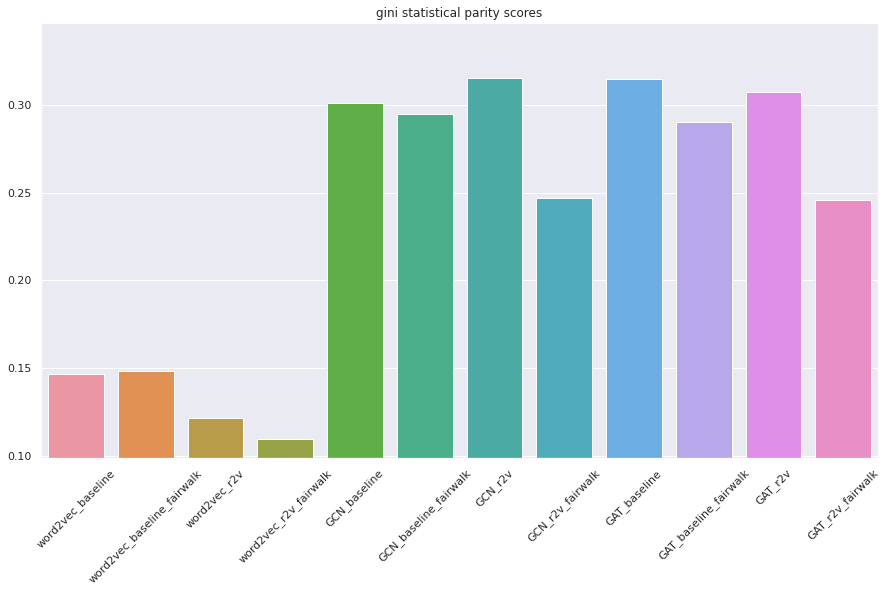

In [43]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9 , max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

word2vec_baseline 0.001847738214459733
word2vec_baseline_fairwalk 0.0019586345147395174
word2vec_r2v 0.001511271119122626
word2vec_r2v_fairwalk 0.001355275658433856
GCN_baseline 0.004722360190206297
GCN_baseline_fairwalk 0.004372502574849588
GCN_r2v 0.0048641268204860505
GCN_r2v_fairwalk 0.0035733945828039892
GAT_baseline 0.004867546644117873
GAT_baseline_fairwalk 0.004268937655253699
GAT_r2v 0.00462171072349961
GAT_r2v_fairwalk 0.003568560045099069


Text(0.5, 1.0, 'statistical parity scores')

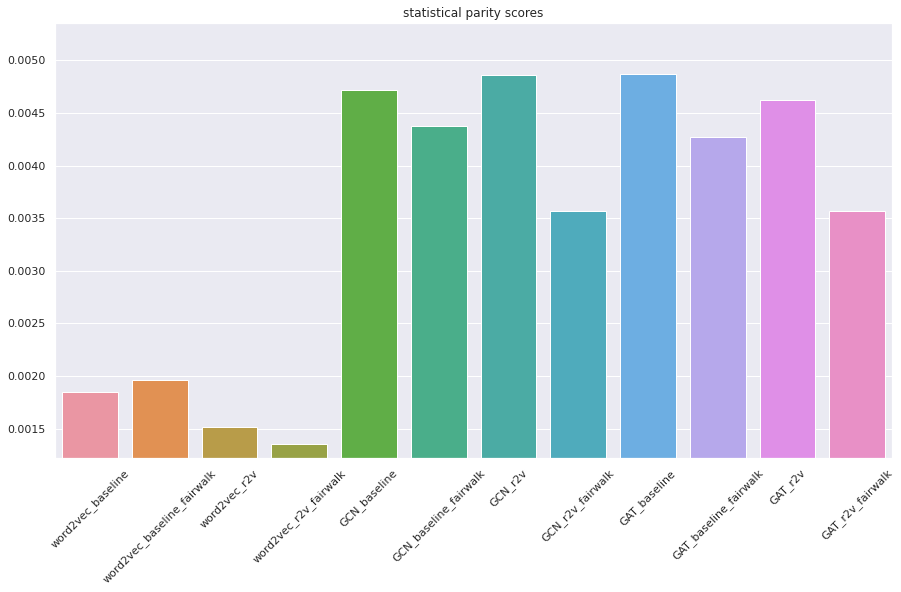

In [44]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

word2vec_baseline 0.7681660899653979
word2vec_baseline_fairwalk 0.7102076124567474
word2vec_r2v 0.7846020761245674
word2vec_r2v_fairwalk 0.643598615916955
GCN_baseline 0.38321799307958476
GCN_baseline_fairwalk 0.606401384083045
GCN_r2v 0.5787197231833909
GCN_r2v_fairwalk 0.6358131487889274
GAT_baseline 0.20761245674740486
GAT_baseline_fairwalk 0.6738754325259515
GAT_r2v 0.3780276816608997
GAT_r2v_fairwalk 0.6730103806228374


Text(0.5, 1.0, 'roc scores')

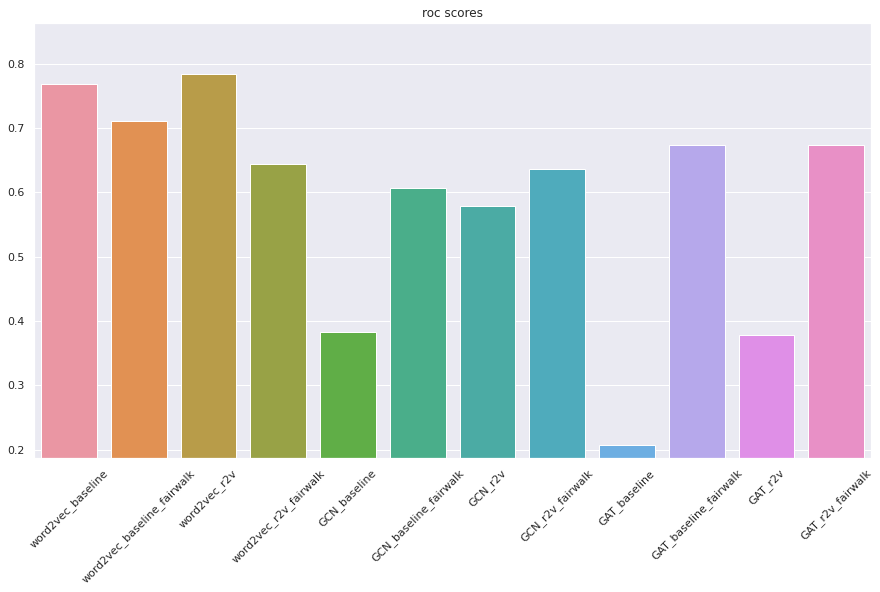

In [45]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [46]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        batch_size =  2000
        A = embs[m]
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, k, batch_size)
        
    
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5412.92it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5610.31it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6544.21it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6587.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6035.97it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6087.81it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5260.56it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5208.83it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6295.74it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6415.72it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5135.02it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6138.05it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6578.88it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5148.35it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5222.65it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5193.08it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5220.31it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5137.81it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5214.78it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5239.02it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6467.13it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5252.35it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5225.11it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6229.06it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6364.49it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6357.85it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6263.37it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5999.45it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6402.72it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6385.46it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6226.33it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6300.24it/s]


Text(0.5, 1.0, 'gini scores vs # nn')

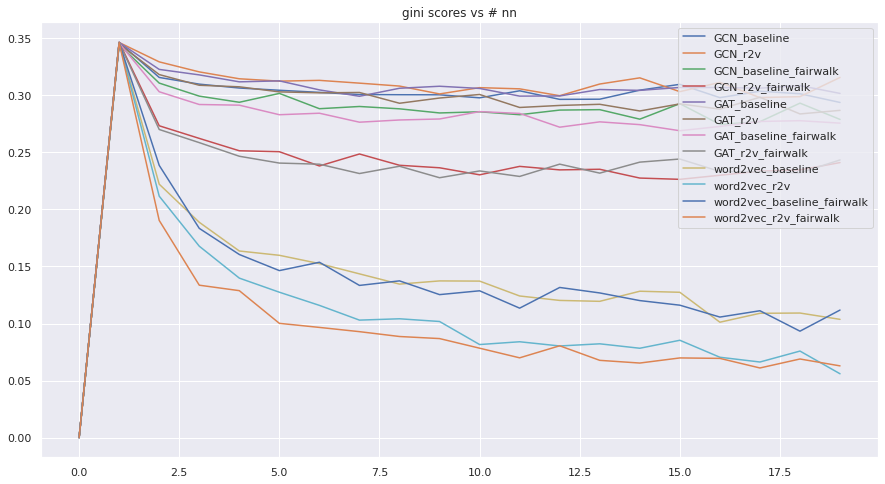

In [47]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

Text(0.5, 1.0, 'sp scores vs # nn')

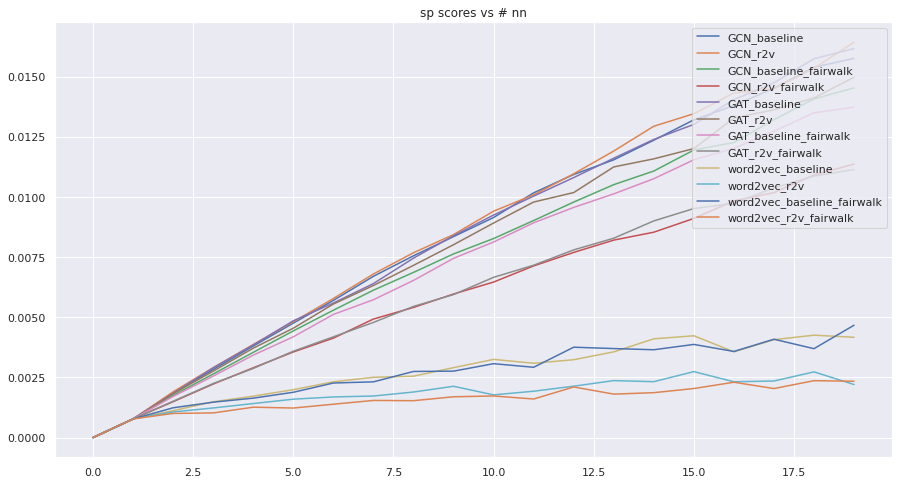

In [48]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [49]:

def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        file = DATA_ROOT + d + DATASET + '_test_adj.npz'
        dot = create_dot_df(A, file)
        scores[idx] = get_roc_score(dot)
    return scores


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, K, batch_size)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return scores, scores_gini

selected edge_idx size: 34
selected edge_idx size: 32
selected edge_idx size: 28
selected edge_idx size: 31
selected edge_idx size: 26
selected edge_idx size: 34
selected edge_idx size: 32
selected edge_idx size: 28
selected edge_idx size: 31
selected edge_idx size: 26
selected edge_idx size: 34
selected edge_idx size: 32
selected edge_idx size: 28
selected edge_idx size: 31
selected edge_idx size: 26
selected edge_idx size: 34
selected edge_idx size: 32
selected edge_idx size: 28
selected edge_idx size: 31
selected edge_idx size: 26
selected edge_idx size: 34
selected edge_idx size: 32
selected edge_idx size: 28
selected edge_idx size: 31
selected edge_idx size: 26
selected edge_idx size: 34
selected edge_idx size: 32
selected edge_idx size: 28
selected edge_idx size: 31
selected edge_idx size: 26
selected edge_idx size: 34
selected edge_idx size: 32
selected edge_idx size: 28
selected edge_idx size: 31
selected edge_idx size: 26
selected edge_idx size: 34
selected edge_idx size: 32
s

Text(0.5, 1.0, 'roc scores')

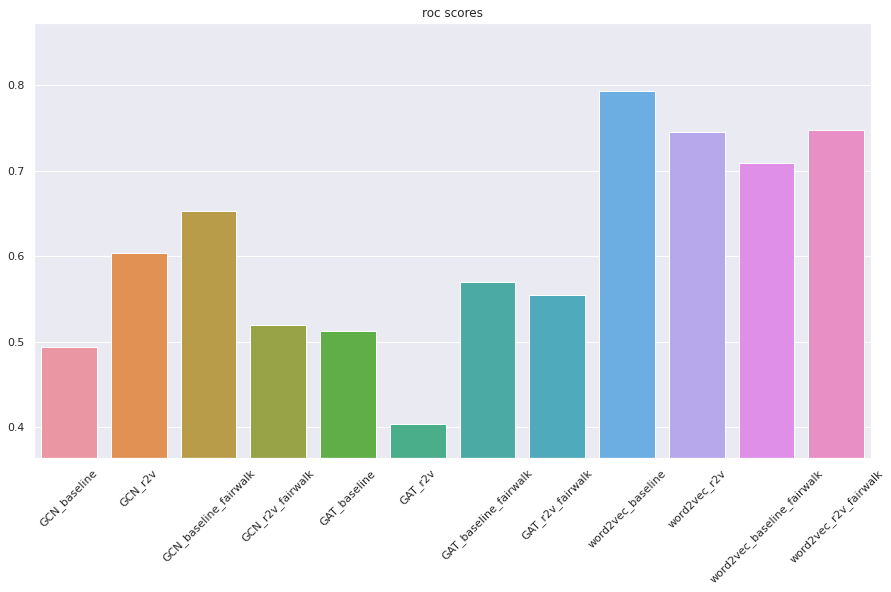

In [50]:

roc_score = {m: np.mean(roc_scores(m)) for m in model_to_embs}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4382.61it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5154.99it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5142.87it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5287.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5287.19it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5254.19it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5313.55it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5082.49it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

GCN_baseline 0.004783608778003147
GCN_r2v 0.004685136527940713
GCN_baseline_fairwalk 0.004232297917603247
GCN_r2v_fairwalk 0.003613562214578963
GAT_baseline 0.004772728638001768
GAT_r2v 0.0047098935823624375
GAT_baseline_fairwalk 0.004236290998624438
GAT_r2v_fairwalk 0.003713056287449701
word2vec_baseline 0.0021246225617216263
word2vec_r2v 0.001519704015076197
word2vec_baseline_fairwalk 0.002076652430765911
word2vec_r2v_fairwalk 0.001374547695965255


Text(0.5, 1.0, 'statistical parity scores')

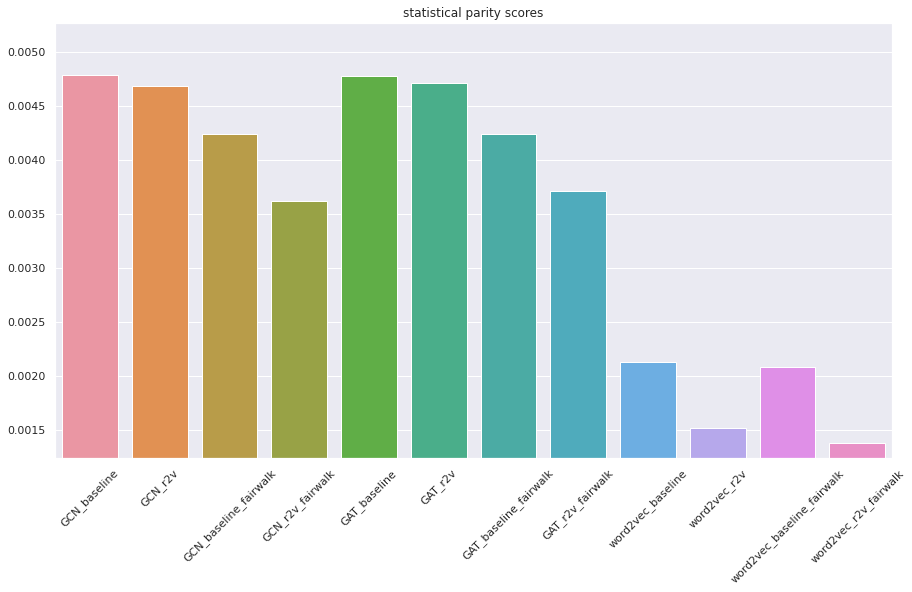

In [51]:

temp = {m: statisticalp_scores(m) for m in model_to_embs}

sp_score = {m: np.mean(v[0]) for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

GCN_baseline 0.3130040707404797
GCN_r2v 0.3085355335508138
GCN_baseline_fairwalk 0.2861848050474368
GCN_r2v_fairwalk 0.25086244079556175
GAT_baseline 0.3107330542348322
GAT_r2v 0.3099237434148794
GAT_baseline_fairwalk 0.2817558777309629
GAT_r2v_fairwalk 0.25465569833989143
word2vec_baseline 0.16559354728831593
word2vec_r2v 0.1278671756305933
word2vec_baseline_fairwalk 0.16180676207365688
word2vec_r2v_fairwalk 0.11283237977071212


Text(0.5, 1.0, 'gini statistical parity scores')

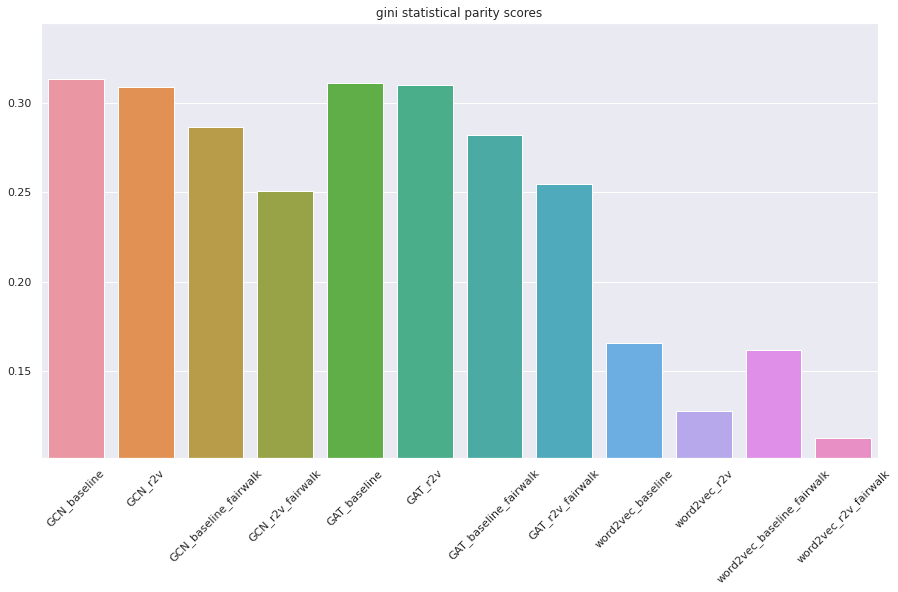

In [52]:
gini_score = {m: np.mean(v[1]) for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9, max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

In [53]:

# roc_score, sp_score, gini_score= {}, {}, {}
roc_score = {m: roc_scores(m) for m in model_to_embs}
temp = {m: statisticalp_scores(m) for m in model_to_embs}
sp_score = {m: v[0] for m,v in temp.items()}
gini_score = {m: v[1] for m,v in temp.items()}
pkl.dump(roc_score, open(DATA_ROOT + "roc_score.pkl", 'wb'))

pkl.dump(sp_score, open(DATA_ROOT + "sp_score.pkl", 'wb'))

pkl.dump(gini_score, open(DATA_ROOT + "gini_score.pkl", 'wb'))

selected edge_idx size: 34
selected edge_idx size: 32
selected edge_idx size: 28
selected edge_idx size: 31
selected edge_idx size: 26
selected edge_idx size: 34
selected edge_idx size: 32
selected edge_idx size: 28
selected edge_idx size: 31
selected edge_idx size: 26
selected edge_idx size: 34
selected edge_idx size: 32
selected edge_idx size: 28
selected edge_idx size: 31
selected edge_idx size: 26
selected edge_idx size: 34
selected edge_idx size: 32
selected edge_idx size: 28
selected edge_idx size: 31
selected edge_idx size: 26
selected edge_idx size: 34
selected edge_idx size: 32
selected edge_idx size: 28
selected edge_idx size: 31
selected edge_idx size: 26
selected edge_idx size: 34
selected edge_idx size: 32
selected edge_idx size: 28
selected edge_idx size: 31
selected edge_idx size: 26
selected edge_idx size: 34
selected edge_idx size: 32
selected edge_idx size: 28
selected edge_idx size: 31
selected edge_idx size: 26
selected edge_idx size: 34
selected edge_idx size: 32
s

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5338.27it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5197.30it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5234.83it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5327.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3632.15it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6310.18it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6517.87it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6345.71it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training